In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0-beta1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.16.2
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


### set_visible_devices

In [2]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
#      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
#      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
#      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
# )

# logical_gpus = tf.config.experimental.list_logical_devices("GPU")
# print(len(logical_gpus))
# tf.config.experimental.set_visible_devices(logical_gpus[0], "GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
logical_gpus = tf.config.experimental.list_logical_devices("GPU")
print(len(logical_gpus))

1


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)


In [5]:
def make_dataset(images, labels, epochs, batch_size,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)
    return dataset

batch_size = 256
epochs = 10

train_dataset = make_dataset(x_train_scaled, y_train, epochs, batch_size)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=512, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=512, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 512)         1

In [8]:
# logdir = './cnn-selu-callbacks'
# if not os.path.exists(logdir):
#     os.mkdir(logdir)
# output_model_file = os.path.join(logdir,
#                                  "fashion_mnist_model.h5")

# callbacks = [
#     keras.callbacks.TensorBoard(logdir),
#     keras.callbacks.ModelCheckpoint(output_model_file,
#                                     save_best_only = True),
#     keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
# ]
# history = model.fit(x_train_scaled, y_train, epochs=10,
#                     validation_data=(x_valid_scaled, y_valid),
#                     callbacks = callbacks)
history = model.fit(train_dataset,
                    steps_per_epoch=x_train_scaled.shape[0] //batch_size, 
                    epochs=10)

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/10
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_803 in device <unspecified>
214/214 [==============================] - 22s 101ms/step - loss: 1.7143 - accuracy

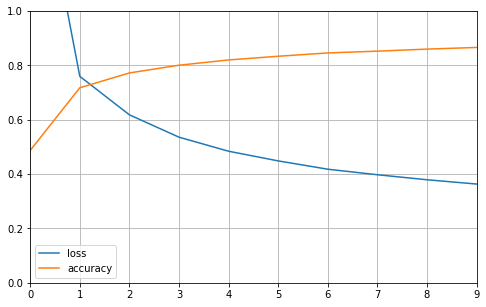

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaled, y_test)

Executing op __inference_keras_scratch_graph_22351 in device <unspecified>
10000/10000 [==============================] - 3s 274us/sample - loss: 0.3945 - accuracy: 0.8577


[0.3945419841766357, 0.8577]